In [24]:
import pandas as pd
from itertools import combinations
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [25]:
preamble = r"""
\usepackage{amsmath}
\usepackage{amssymb}
"""

mpl.rcParams.update(
    {
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",
        "pgf.preamble": preamble,
        "text.latex.preamble": preamble,
        "font.size": 11,
        "font.family": "serif",
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "figure.figsize": np.array([7.05826, 4]),
        "figure.dpi": 200,
        "savefig.dpi": 72.27,
        "savefig.pad_inches": 0.01,
    }
)



## Read Data


In [26]:
df_kunde = pd.read_excel(r"C:\Users\Vera\Downloads\Kundendatei.xlsx")
df_beispiel = pd.read_excel(r"C:\Users\Vera\Downloads\Beispielobjekte.xlsx", sheet_name=0)
df_katalog=pd.read_excel(r"C:\Users\Vera\Downloads\EP_Katalog.xlsx")

# Function

In [27]:
 # For each group, flatten the selected columns and join their values into a single lowercase string

def combine_columns(df, group_col, cols):
    return (
        df.groupby(group_col)[cols]
        .apply(lambda x: ' '.join(str(v).lower() for row in x.values for v in row if pd.notna(v)))
        .reset_index(name='combined_text')
    )


# Other, Combine all possibilities of Colums

In [28]:
kunde_spalten = ['EQ-Bezeichnung', 'EQ-Klasse', 'EQ-Klasse-Bezeichnung', 'Anlagenausprägung']
beispiel_spalten = ['Anlagenname', 'AKS-Bezeichnung', 'Kostengruppenbezeichnung']
# Generate all meaningful column combinations (1 to all columns)
kunde_combos = sum([list(combinations(kunde_spalten, r)) for r in range(1, len(kunde_spalten)+1)], [])
beispiel_combos = sum([list(combinations(beispiel_spalten, r)) for r in range(1, len(beispiel_spalten)+1)], [])


# Task 1: 

Start with Tf-IdfVectorizer

In [29]:
all_matches = []  # List to collect all matching results

# Loop over all combinations of customer columns and example columns
for k_cols in kunde_combos:
    for b_cols in beispiel_combos:

        # Combine the specified columns for customer data grouped by 'WirtEinh'
        kunde_text = combine_columns(df_kunde, 'WirtEinh', list(k_cols))
        # Combine the specified columns for example data grouped by 'Gebäude-ID'
        beispiel_text = combine_columns(df_beispiel, 'Gebäude-ID', list(b_cols))

        # Concatenate all combined texts (customer + example) for vectorization
        all_texts = list(kunde_text['combined_text']) + list(beispiel_text['combined_text'])

        # Initialize TF-IDF vectorizer
        vectorizer = TfidfVectorizer()
        # Fit and transform all texts to TF-IDF vectors
        tfidf_matrix = vectorizer.fit_transform(all_texts)

        # Split the TF-IDF matrix back into customer and example parts
        tfidf_kunde = tfidf_matrix[:len(kunde_text)]
        tfidf_beispiel = tfidf_matrix[len(kunde_text):]

        # Compute cosine similarity matrix between customer and example TF-IDF vectors
        cosine_scores = cosine_similarity(tfidf_kunde, tfidf_beispiel)

        # For each customer entry, find the example entry with highest similarity
        for i, row in enumerate(cosine_scores):
            best_idx = row.argmax()     # index of best matching example
            best_score = row[best_idx]  # similarity score

            # Append match info to all_matches list
            all_matches.append({
                'WirtEinh': kunde_text.iloc[i]['WirtEinh'],               # Customer entity ID
                'Matched_Gebäude_ID': beispiel_text.iloc[best_idx]['Gebäude-ID'],  # Matched example ID
                'Similarity': best_score,                                  # Cosine similarity score
                'Kunde_Cols': ', '.join(k_cols),                          # Columns used from customer data
                'Beispiel_Cols': ', '.join(b_cols)                        # Columns used from example data
            })

# Convert all matches into a DataFrame and sort by similarity descending
matches_df = pd.DataFrame(all_matches)
matches_df = matches_df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

# Filter matches with similarity above threshold (0.02 here) and print top 10
top_matches = matches_df[matches_df['Similarity'] > 0.02]
print(top_matches.head(10))

   WirtEinh  Matched_Gebäude_ID  Similarity  \
0     15859                2095    0.079792   
1     26287                2026    0.076854   
2     26287                2026    0.071586   
3     26287                2026    0.069006   
4     26287                2026    0.065672   
5     15859                2095    0.063914   
6     15859                2095    0.060899   
7     22225                2026    0.057562   
8     21083                2104    0.055687   
9     22225                2026    0.054418   

                                 Kunde_Cols  \
0                            EQ-Bezeichnung   
1                            EQ-Bezeichnung   
2                            EQ-Bezeichnung   
3                            EQ-Bezeichnung   
4                            EQ-Bezeichnung   
5                            EQ-Bezeichnung   
6                            EQ-Bezeichnung   
7                            EQ-Bezeichnung   
8  EQ-Klasse-Bezeichnung, Anlagenausprägung   
9           

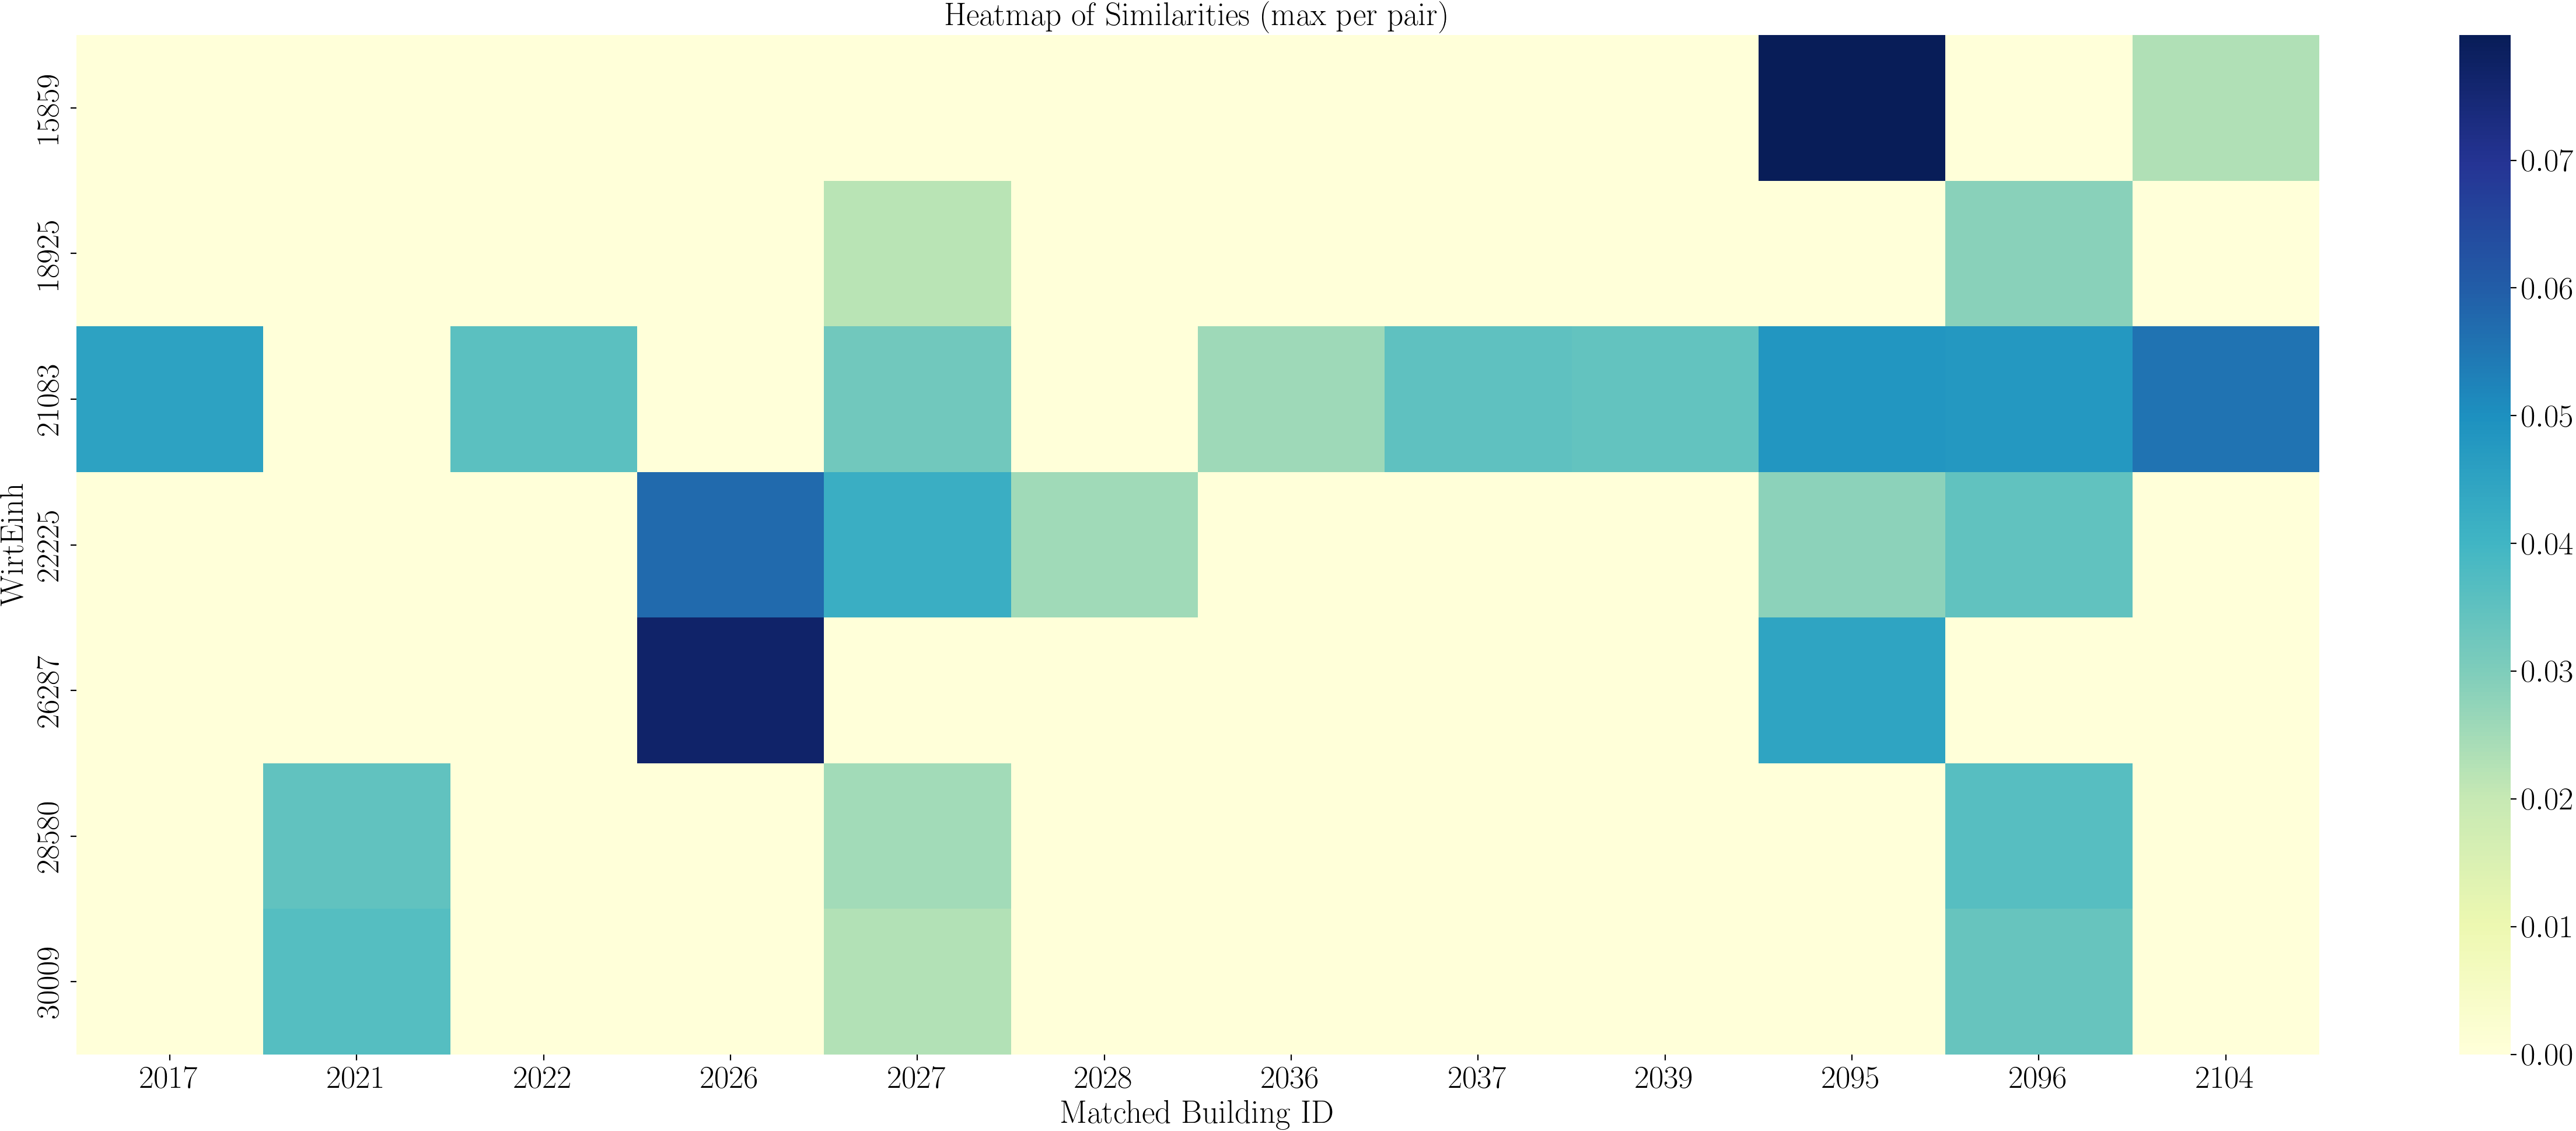

In [30]:
# Create a pivot table from the top matches

pivot_df = top_matches.pivot_table(
    index='WirtEinh', 
    columns='Matched_Gebäude_ID', 
    values='Similarity', 
    aggfunc='max', 
    fill_value=0
)


plt.figure(figsize=(25, 10))

# Plot a heatmap of the pivot table 
sns.heatmap(pivot_df, cmap='YlGnBu', annot=False)

# Set title and axis labels for the plot
plt.title('Heatmap of Similarities (max per pair)')
plt.xlabel('Matched Building ID')
plt.ylabel('WirtEinh')


plt.tight_layout()
plt.show()

 Too little similarity, use new model:


#	SentenceTransformer

In [31]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

all_matches = []

# Loop through all combinations of customer columns and example columns
for k_cols in kunde_combos:
    for b_cols in beispiel_combos:

        # Combine specified columns into a single text field for customers and examples
        kunde_text = combine_columns(df_kunde, 'WirtEinh', list(k_cols))
        beispiel_text = combine_columns(df_beispiel, 'Gebäude-ID', list(b_cols))

        # Compute embeddings (vector representations) for the combined texts using the SentenceTransformer model
        embeddings_kunde = model.encode(kunde_text['combined_text'], convert_to_tensor=True)
        embeddings_beispiel = model.encode(beispiel_text['combined_text'], convert_to_tensor=True)

        # Calculate cosine similarity between customer embeddings and example embeddings
        cosine_scores = util.cos_sim(embeddings_kunde, embeddings_beispiel).cpu().numpy()

        # For each customer text, find the best matching example text (highest similarity score)
        for i, row in enumerate(cosine_scores):
            best_idx = row.argmax()
            best_score = row[best_idx]

            # Store the matching results in a list with relevant info
            all_matches.append({
                'WirtEinh': kunde_text.iloc[i]['WirtEinh'],                # Customer unit identifier
                'Matched_Gebäude_ID': beispiel_text.iloc[best_idx]['Gebäude-ID'],  # Matched example building ID
                'Similarity': best_score,                                  # Similarity score of the match
                'Kunde_Cols': ', '.join(k_cols),                          # Customer columns used for matching
                'Beispiel_Cols': ', '.join(b_cols)                        # Example columns used for matching
            })

# Convert the collected match results into a DataFrame and sort by similarity score descending
matches_df = pd.DataFrame(all_matches)
matches_df = matches_df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

# Filter to keep only the top matches with similarity greater than 0.64
top_matches = matches_df[matches_df['Similarity'] > 0.64]

# Print the top 10 matches
print(top_matches.head(10))


c:\Users\Vera\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Vera\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Vera\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Vera\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in

   WirtEinh  Matched_Gebäude_ID  Similarity  \
0     22225                2032    0.837778   
1     21083                2041    0.829181   
2     22225                2021    0.824131   
3     21083                2104    0.822024   
4     21083                2017    0.821339   
5     21083                2017    0.815371   
6     21083                2041    0.814823   
7     26287                2017    0.810780   
8     21083                2038    0.810289   
9     26287                 546    0.809299   

                                 Kunde_Cols  \
0                     EQ-Klasse-Bezeichnung   
1  EQ-Klasse-Bezeichnung, Anlagenausprägung   
2                     EQ-Klasse-Bezeichnung   
3                     EQ-Klasse-Bezeichnung   
4  EQ-Klasse-Bezeichnung, Anlagenausprägung   
5                     EQ-Klasse-Bezeichnung   
6  EQ-Klasse-Bezeichnung, Anlagenausprägung   
7     EQ-Bezeichnung, EQ-Klasse-Bezeichnung   
8  EQ-Klasse-Bezeichnung, Anlagenausprägung   
9     EQ-Bez

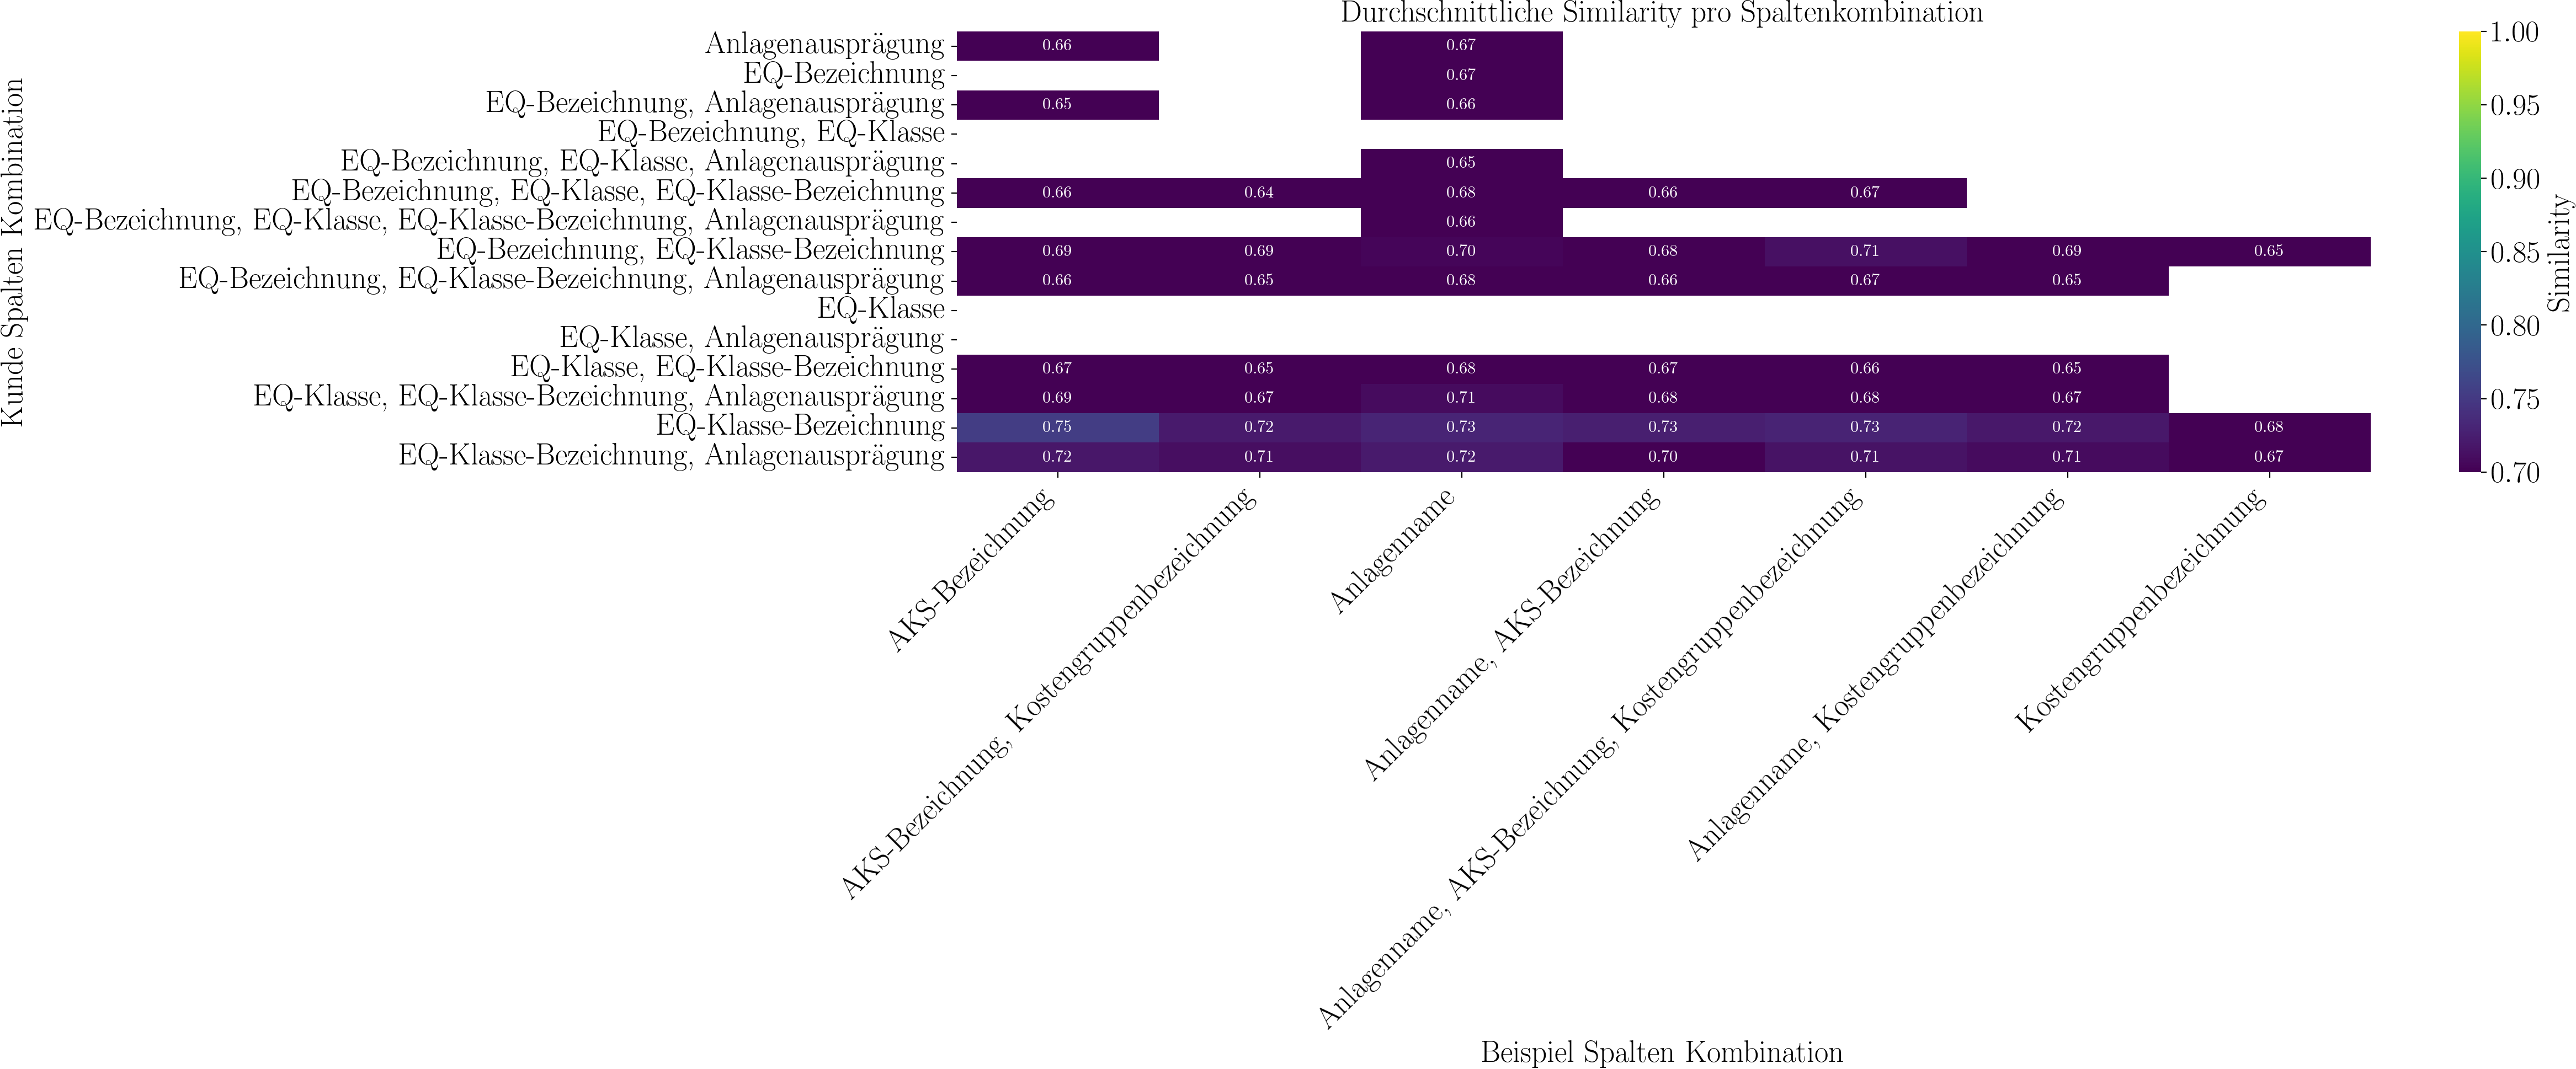

In [32]:
# Create a pivot table from the top matches
pivot_table = matches_df.pivot_table(
    index='Kunde_Cols',
    columns='Beispiel_Cols',
    values='Similarity',
    aggfunc='mean'
)

# Mask values below 0.7 (replace with NaN)
filtered_pivot = pivot_table.where(pivot_table > 0.64, np.nan)

plt.figure(figsize=(25, 10))
sns.heatmap(filtered_pivot, annot=True, fmt=".2f", cmap='viridis', vmin=0.7, vmax=1, cbar_kws={'label': 'Similarity'})

plt.title('Durchschnittliche Similarity  pro Spaltenkombination ')
plt.xlabel('Beispiel Spalten Kombination')
plt.ylabel('Kunde Spalten Kombination')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Höchste Übereinstimmung mit AKS-Bezeichnung und EQ-Klasse-Bezeichnung


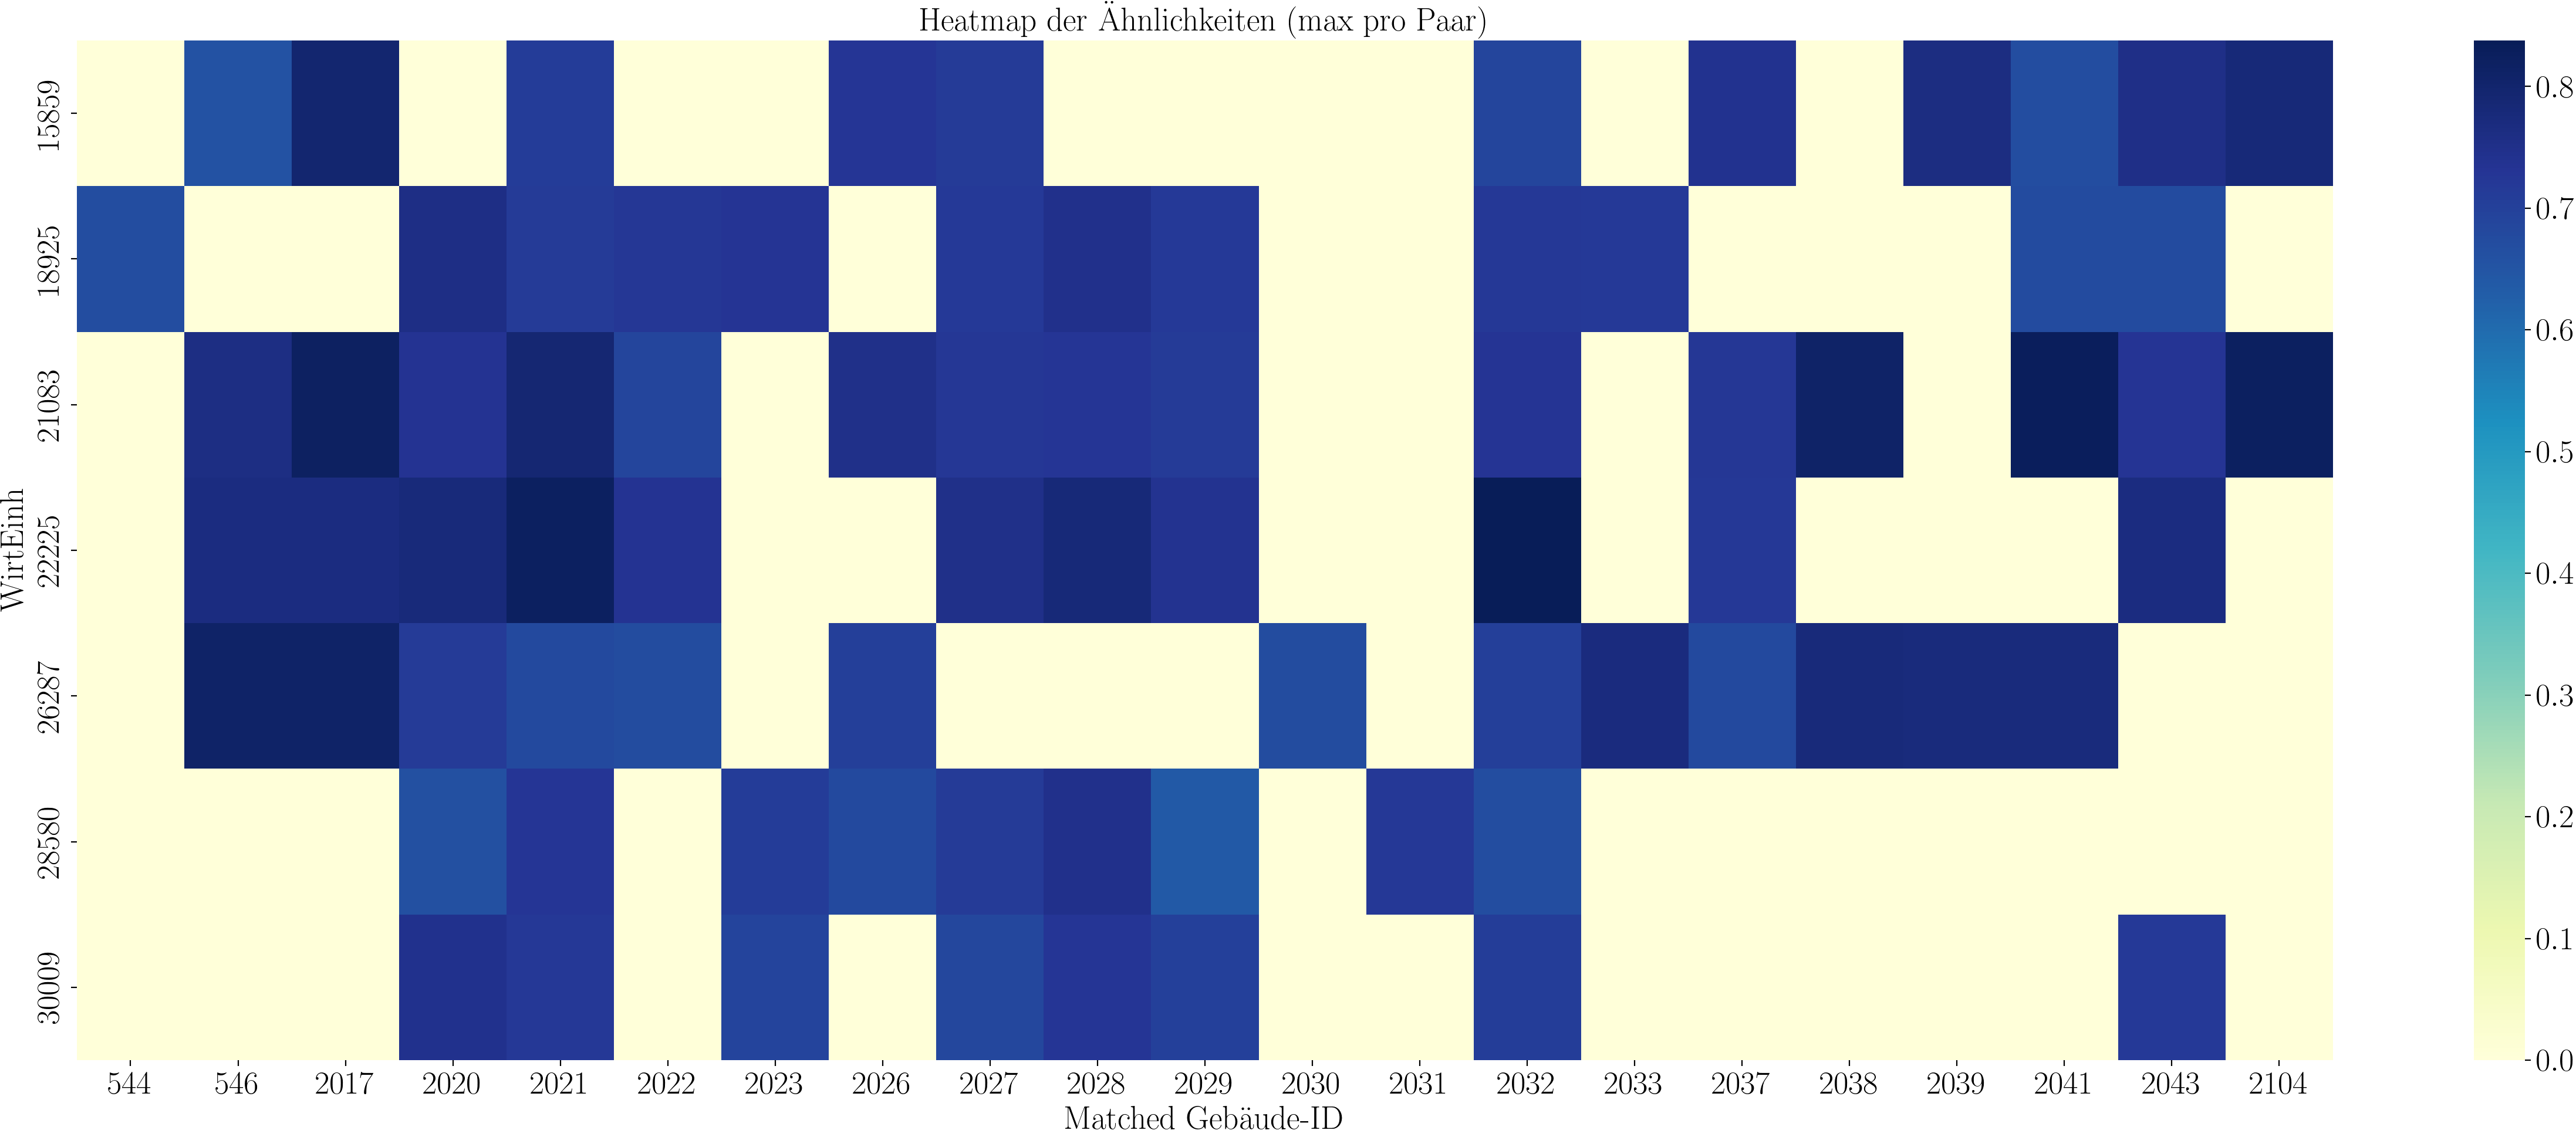

In [33]:
pivot_df = top_matches.pivot_table(
    index='WirtEinh', columns='Matched_Gebäude_ID', values='Similarity', aggfunc='max', fill_value=0
)

plt.figure(figsize=(25, 10))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=False)
plt.title('Heatmap der Ähnlichkeiten (max pro Paar)')
plt.xlabel('Matched Gebäude-ID')
plt.ylabel('WirtEinh')
plt.tight_layout()
plt.show()

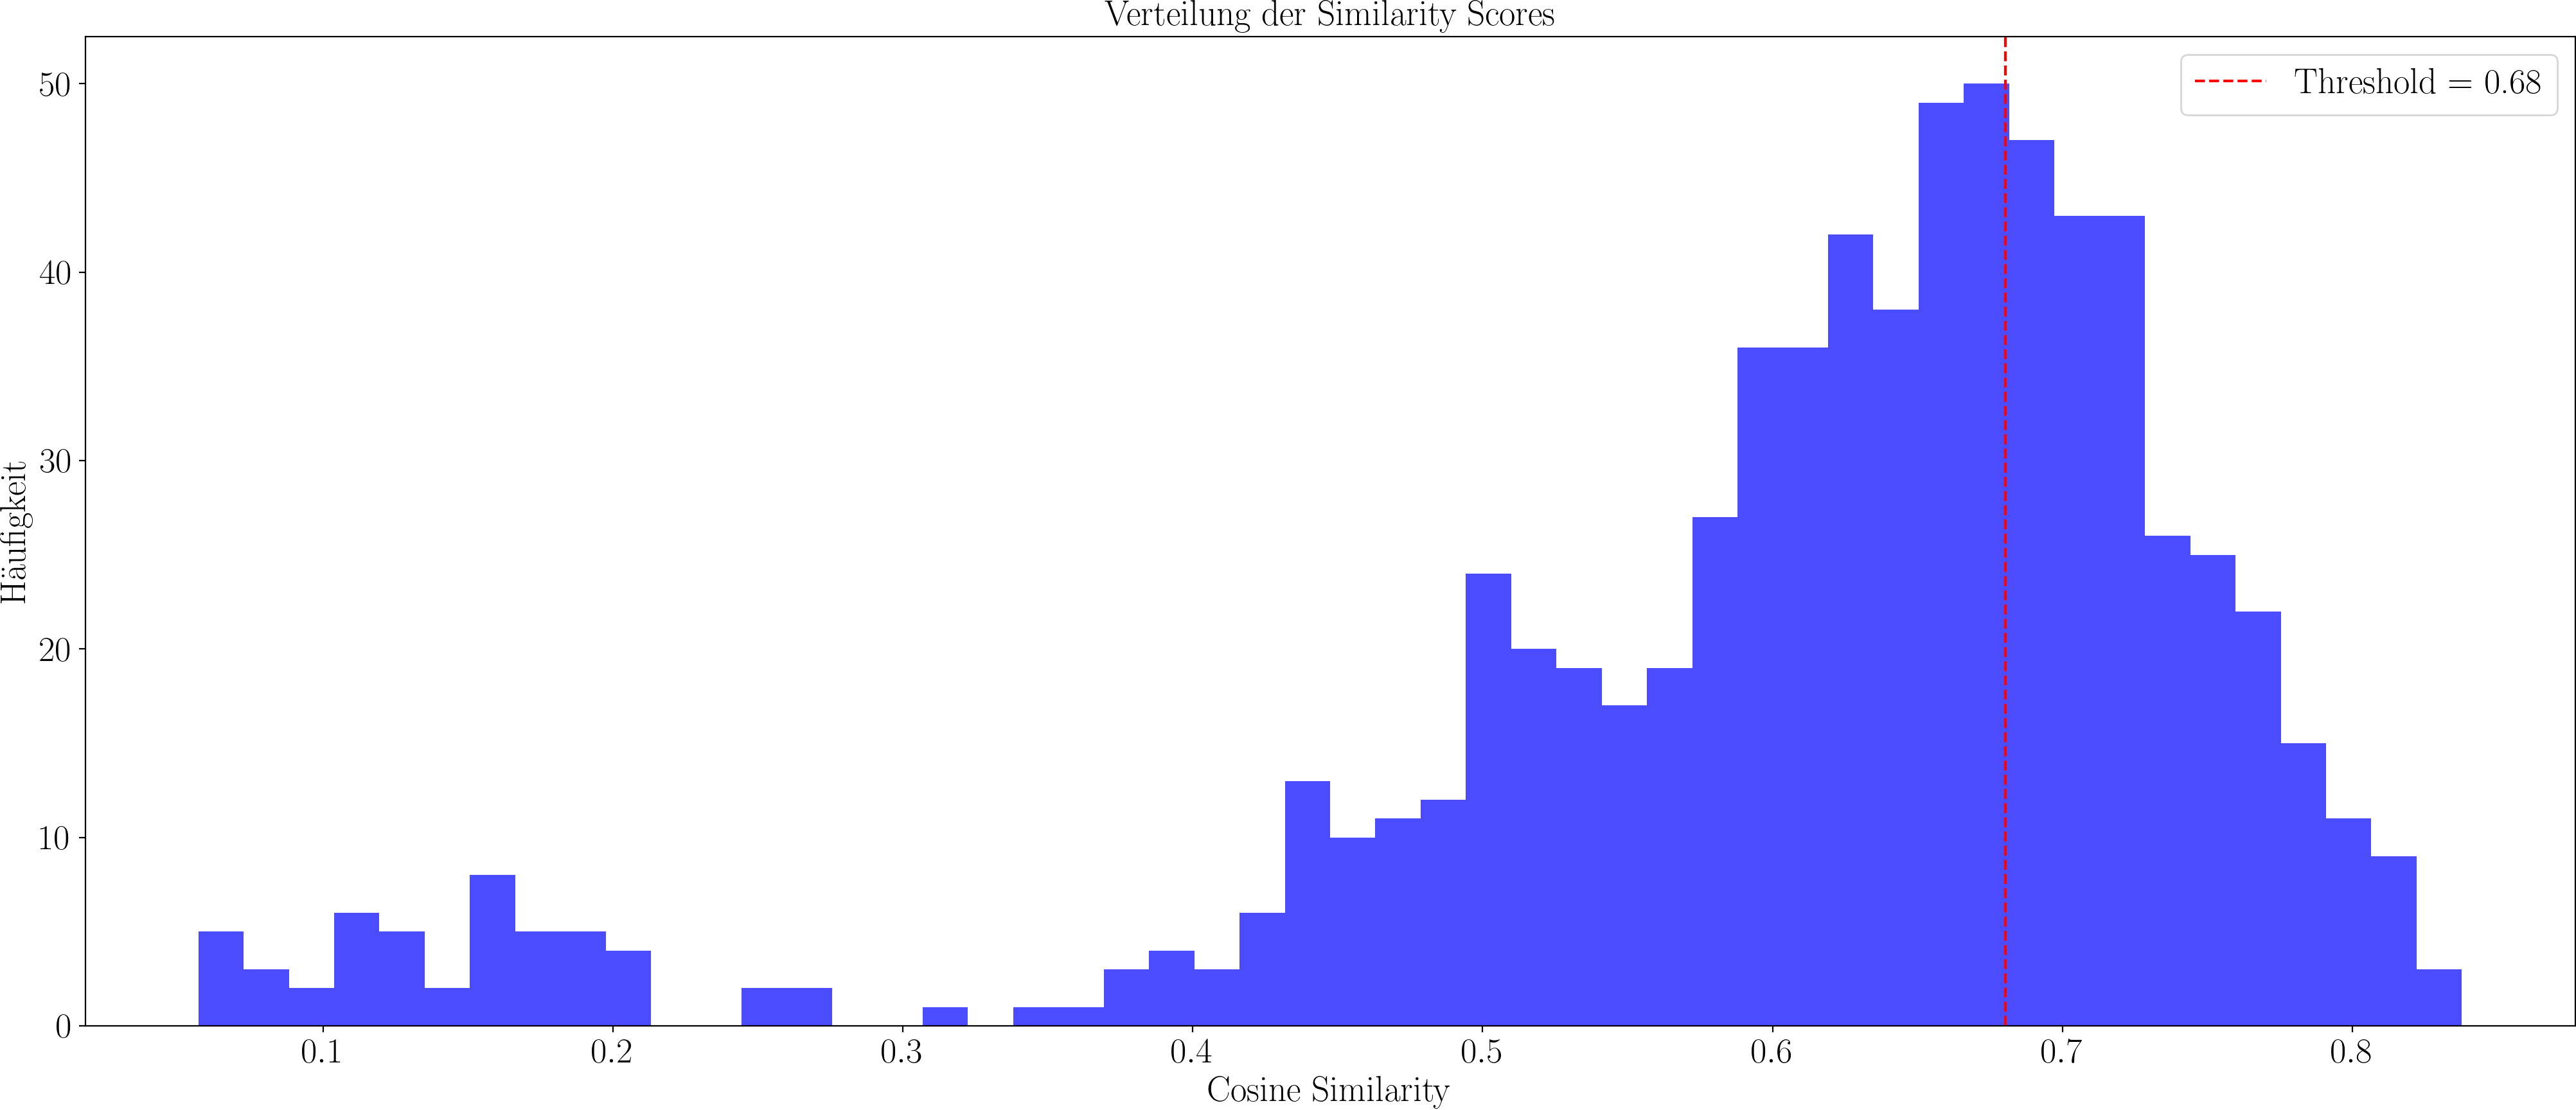

In [34]:
all_scores = [match['Similarity'] for match in all_matches]

mean_score = np.mean(all_scores)
std_score = np.std(all_scores)

# Threshold festlegen 
threshold = mean_score + 0.5 * std_score

# Plot Histogram
plt.figure(figsize=(25, 10))  
plt.hist(all_scores, bins=50, alpha=0.7, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('Verteilung der Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Häufigkeit')
plt.legend()
plt.show()

In [35]:

# Threshold 
threshold = 0.64
#	Global: the highest similarity value per Wirt_einh across all matches
best_scores = {}

for match in all_matches:
    wirt_einh = match['WirtEinh']
    score = match['Similarity']
    if wirt_einh not in best_scores or score > best_scores[wirt_einh]:
        best_scores[wirt_einh] = score

#change DataFrame 
best_scores_df = pd.DataFrame([
    {'WirtEinh': w, 'MaxSimilarity': s}
    for w, s in best_scores.items()
])

# separate
vollstaendig_df = best_scores_df[best_scores_df['MaxSimilarity'] >= threshold]
unvollstaendig_df = best_scores_df[best_scores_df['MaxSimilarity'] < threshold]

pfad_vollstaendig = r'C:\Users\Vera\Downloads\vollstaendige_gebäude.csv'
pfad_unvollstaendig = r'C:\Users\Vera\Downloads\unvollstaendige_gebäude.csv'

vollstaendig_df.to_csv(pfad_vollstaendig, index=False)
unvollstaendig_df.to_csv(pfad_unvollstaendig, index=False)

print('Vollständige Gebäude:', vollstaendige_gebäude)
print('Unvollständige Gebäude:', unvollstaendige_gebäude)

Vollständige Gebäude: [15859, 18925, 21083, 22225, 26287, 28580, 30009]
Unvollständige Gebäude: []


## Task 2

In [ ]:
# Load model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Select all columns in df_kunde that start with 'EQ-Merkmal_'
merkmal_cols = [col for col in df_kunde.columns if col.startswith('EQ-Merkmal_')]

# Combine EQ class and all feature columns into one text string per row
# Fill missing values with '', then join features with spaces
kunde_texts = (
    df_kunde['EQ-Klasse-Bezeichnung'].fillna('') + ' ' +
    df_kunde[merkmal_cols].fillna('').agg(' '.join, axis=1)
).str.lower().tolist()

#Prepare catalog texts 
katalog_texts = df_katalog['Kurztext / Bezeichnung'].fillna('').str.lower().tolist()

# Compute sentence embeddings 
embeddings_kunde = model.encode(kunde_texts, convert_to_tensor=True)
embeddings_katalog = model.encode(katalog_texts, convert_to_tensor=True)

# Compute cosine similarity between all customer and catalog entries 
cosine_scores = util.cos_sim(embeddings_kunde, embeddings_katalog).cpu().numpy()

# Find the best match for each customer entry 
results = []
for i, scores in enumerate(cosine_scores):
    best_idx = scores.argmax()
    best_score = scores[best_idx]

    # Get Artikelnummer or set fallback message
    artikelnummer = (
        df_katalog.loc[best_idx, 'Artikelnummer']
        if 'Artikelnummer' in df_katalog.columns and pd.notna(df_katalog.loc[best_idx, 'Artikelnummer'])
        else 'Keine Artikelnummer verfügbar'
    )

    # Add result to list
    results.append({
        'EQ-Klasse-Bezeichnung': df_kunde.loc[i, 'EQ-Klasse-Bezeichnung'],
        'Matched_Katalog_Bezeichnung': df_katalog.loc[best_idx, 'Kurztext / Bezeichnung'],
        'Artikelnummer': artikelnummer,
        'Similarity': best_score
    })

# === Create and sort final DataFrame ===
matches_df = pd.DataFrame(results).sort_values(by='Similarity', ascending=False)

print(matches_df)


c:\Users\Vera\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
similarities = matches_df['Similarity']

#Calculate Threshold 
mean_score = np.mean(similarities)
std_score = np.std(similarities)
threshold = mean_score + 0.5 * std_score

# Histogram
plt.figure(figsize=(25,10))
plt.hist(similarities, bins=30, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('Verteilung der Similarity Scores (Kunde → Katalog)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Anzahl der Matches')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f'Automatisch berechneter Threshold: {threshold:.2f}')



In [ ]:
top_matches = matches_df[matches_df['Similarity'] >= threshold]

speicherpfad = r'C:\Users\Vera\Downloads\top_matches.csv'
top_matches.to_csv(speicherpfad, index=False)
